## Chesapeake Bay Bloom 2025 (July 21) - Looking at the Rrs Spectra

Login to NASA Earth Access

In [1]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

Select the date and set the ROI bbox

In [2]:
bbox = (-76.903, 37.873, -75.608, 39.659)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_AOP",
    temporal = ("2025-07-22", "2025-07-22"),
    bounding_box = bbox
)

len(results)

1

In [3]:
# look at the file names to make sure they are ok
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250722T173005.L2.OC_AOP.V3_1.nc']]

In [4]:
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

This is level 2 data and unlike level 3 data, it has groups. We need to use `open_datatree()` and `merge().

In [5]:
# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

In [6]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    latitude       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength     (number_of_bands) float64 2kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_gain      (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_offset    (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    F0             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    aw             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    bbw            (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    ...             ...
    aot_865        (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    angstrom       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    avw            (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    nflh           (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    tilt           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20250722T173005.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data1/sdpsoper/vdc/vpu0/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -92.374756
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9688000679016113
    geospatial_bounds:                 POLYGON ((-59.96334 45.67412, -92.3747...

In [7]:
# Fix a chunk mismatch and check the chunking; ignore the warning
# We are good for dask backed operations
ds = ds.unify_chunks()
ds.chunks

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/structure/chunks.py:180: PerformanceWarning: Increasing number of chunks by factor of 81
  _, chunked_data = chunkmanager.unify_chunks(*unify_chunks_args)


Frozen({'number_of_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_reflective_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_lines': (32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14), 'pixels_per_line': (256, 256, 256, 256, 248), 'wavelength_3d': (40, 40, 40, 40, 12)})

## Let's open it up!

Let's load up our libraries, and then extract the relevant data we need. 

In [8]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize

In [9]:
# Assign core variables; for convenience during plotting
rrs_da = ds["Rrs"]
avw_da = ds["avw"]
wavelengths = ds["wavelength_3d"]

In [ ]:
# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# Get the figure set up, add a map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Put some lines in there so we know where we are
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop the image down a bit so we can focus on an area
ax.set_extent([-76.9, -75.6, 37.9, 39.7], crs=ccrs.PlateCarree())

# Plot and adjust colorbar limits, put "pad" argument in there to move the colorbar away from the image (otherwise it overlaps)
img = avw_da.plot(x="longitude", y="latitude", cmap="jet", vmin=vmin, vmax=vmax, ax=ax, cbar_kwargs={"pad": 0.1})


fig.savefig(
    'AVW_22072025_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)


In [10]:
# This takes a few seconds to run
# rrs_da is a dask array (chunked). We use .compute() for force it to compute now
brightness = rrs_da.integrate(coord='wavelength_3d').compute()

Let's just do a quick comparison of the two spectral rasters - AVW (focused on spectral shape), and brightness (focused on spectral magnitude).

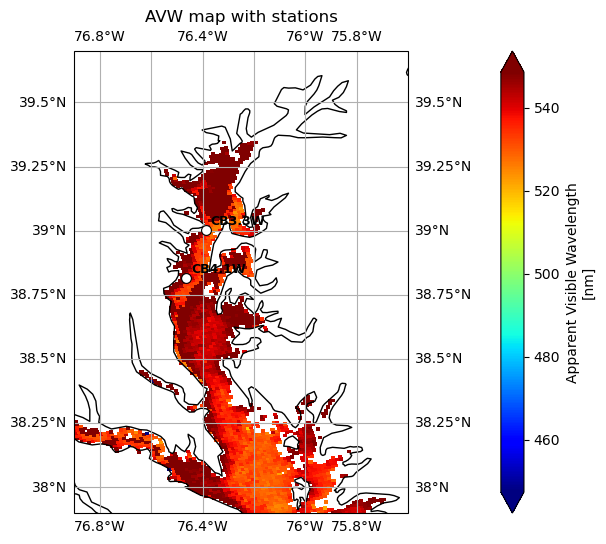

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Outlier clipping
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

#vmin_q = float(avw_da.quantile(0.01))
#vmax_q = float(avw_da.quantile(0.99))

#vmin = max(520, vmin_q)   # don’t let the colorbar start below 520
#vmax = vmax_q

# Figure with map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Gridlines and coastlines
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop map to region of interest
ax.set_extent([-76.9, -75.6, 37.9, 39.7], crs=ccrs.PlateCarree())

# Plot the data
img = avw_da.plot(
    x="longitude",
    y="latitude",
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
    ax=ax,
    cbar_kwargs={"pad": 0.1}
)

# Stations
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149,-76.4627),
]


# Overlay station points
for name, lat, lon in stations:
    ax.scatter(lon, lat, s=50, color="white", edgecolor="black", linewidth=0.8, zorder=5)
    ax.text(lon + 0.02, lat + 0.02, name, fontsize=9, color="black", fontweight="bold", zorder=6)

plt.title("AVW map with stations")
fig.savefig(
    'AVW_WithStations_22072025_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

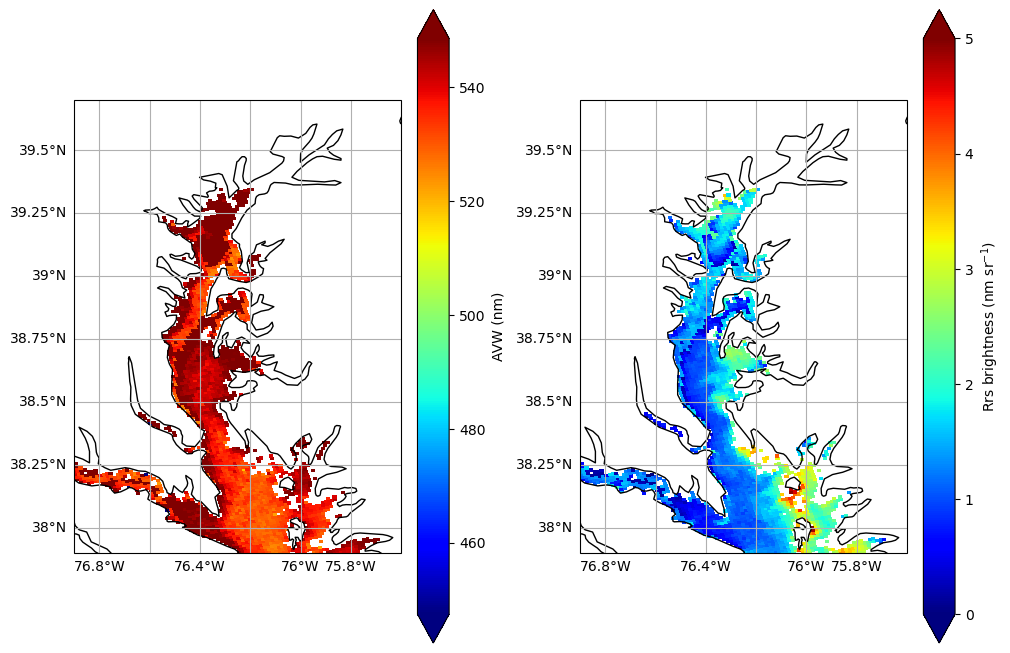

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# AVW
avw_da.plot(ax=axes[0], x="longitude", y="latitude",cmap="jet", vmin=vmin, vmax=vmax,
    cbar_kwargs={"shrink": 0.8, "label": "AVW (nm)"})
axes[0].set_extent([-76.9, -75.6, 37.9, 39.7])
axes[0].coastlines()
axes[0].gridlines(draw_labels={"bottom": "x", "left": "y"})

# Brightness
brightness.plot(ax=axes[1], x="longitude", y="latitude", cmap="jet", vmin=0, vmax=5,
    cbar_kwargs={"shrink": 0.8, "label": "Rrs brightness (nm sr$^{-1}$)"})
axes[1].set_extent([-76.9, -75.6, 37.9, 39.7])
axes[1].coastlines()
axes[1].gridlines(draw_labels={"bottom": "x", "left": "y"})

fig.savefig(
    'AVW_RrsBrightness_22072025_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

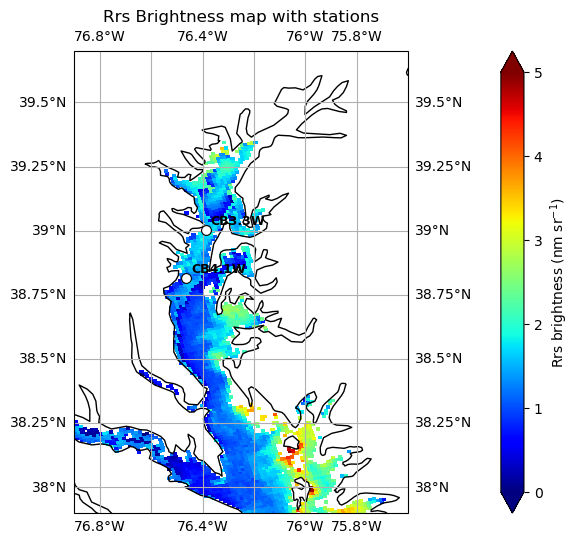

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


# Figure with map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Gridlines and coastlines
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop map to region of interest
ax.set_extent([-76.9, -75.6, 37.9, 39.7], crs=ccrs.PlateCarree())

# Plot the data
img = brightness.plot(
    x="longitude",
    y="latitude",
    cmap="jet",
    vmin=0,
    vmax=5,
    ax=ax,
    cbar_kwargs={"pad": 0.1, "label": "Rrs brightness (nm sr$^{-1}$)"}
)


# Stations
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149,-76.4627),
]


# Overlay station points
for name, lat, lon in stations:
    ax.scatter(lon, lat, s=50, color="white", edgecolor="black", linewidth=0.8, zorder=5)
    ax.text(lon + 0.02, lat + 0.02, name, fontsize=9, color="black", fontweight="bold", zorder=6)

plt.title("Rrs Brightness map with stations")
fig.savefig(
    'Brightness_WithStations_22072025_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Plot
rrs = ds['Rrs'].sel(
    wavelength_3d=443,  method='nearest')
rrs.plot(robust=True, 
         x="longitude", y="latitude",
         xlim=(-71.7, -67.8), ylim=(40.6, 43.5));


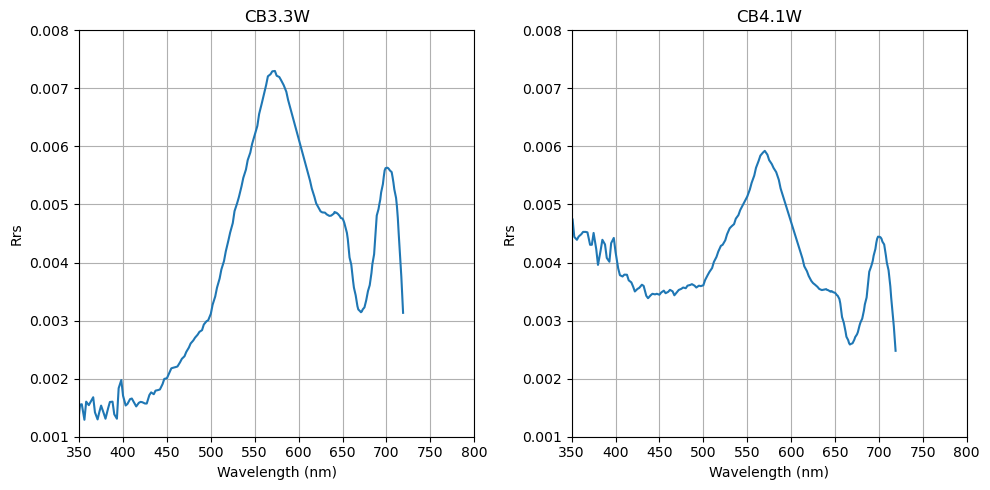

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Stations
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149,-76.4627),
]

# Lat/lon grids
lat_grid = ds["latitude"].values
lon_grid = ds["longitude"].values

# Number of stations
n_stations = len(stations)

# Create a grid of subplots (adjust rows/cols as needed)
ncols = 2
nrows = 1 # ceil division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, (name, plat, plon) in enumerate(stations):
    # Compute distances to all pixels
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    
    # Extract spectrum
    spectrum = ds["Rrs"].isel(number_of_lines=y, pixels_per_line=x)
    
    # Plot in its own subplot
    ax = axes[i]
    spectrum.plot.line(x="wavelength_3d", ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Rrs")
    ax.set_ylim(0.001, 0.008)
    ax.set_xlim(350, 800)
    ax.grid(True)

# Hide any extra subplots if n_stations < nrows*ncols
for j in range(n_stations, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
#fig.savefig(
    #'SpectraForStations_22072025_ChesBay.png',
    #dpi=300,
    #bbox_inches='tight'
#)
plt.show()

In [ ]:
xxxxxxxxxxxx

In [11]:
import earthaccess
auth_rhos = earthaccess.login()

# are we authenticated?
if not auth_rhos.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth_rhos.login(strategy="interactive", persist=True)

bbox_rhos = (-76.903, 37.873, -75.608, 39.659)

import xarray as xr
results_rhos = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=("2025-07-22", "2025-07-22"),
    bounding_box=bbox_rhos
)

len(results_rhos)

# look at the file names to make sure they are ok
[res.data_links() for res in results_rhos]

fileset_rhos = earthaccess.open(results_rhos)

# open_datatree is for netcdf files with groups
datatree_rhos = xr.open_datatree(
    fileset_rhos[0],
    decode_timedelta=False,
    chunks={}
)
datatree_rhos.groups

ds_rhos = xr.merge(datatree_rhos.to_dict().values())
ds_rhos = ds_rhos.set_coords(("longitude", "latitude"))
ds_rhos

ds_rhos = ds_rhos.unify_chunks()
ds_rhos.chunks


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/structure/chunks.py:180: PerformanceWarning: Increasing number of chunks by factor of 81
  _, chunked_data = chunkmanager.unify_chunks(*unify_chunks_args)


Frozen({'number_of_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_reflective_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_lines': (32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14), 'pixels_per_line': (256, 256, 256, 256, 248), 'wavelength_3d': (40, 40, 40, 2)})

In [12]:
rhos_da = ds_rhos["rhos"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Stations
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149,-76.4627),
]

# Lat/lon grids
lat_grid = ds["latitude"].values
lon_grid = ds["longitude"].values

# Number of stations
n_stations = len(stations)

# Create a grid of subplots (adjust rows/cols as needed)
ncols = 2
nrows = 1 # ceil division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, (name, plat, plon) in enumerate(stations):
    # Compute distances to all pixels
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    
    # Extract spectrum
    spectrum = ds["rhos"].isel(number_of_lines=y, pixels_per_line=x)
    
    # Plot in its own subplot
    ax = axes[i]
    spectrum.plot.line(x="wavelength_3d", ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("rhos")
    #ax.set_ylim(-0.006, 0.002)
    ax.set_xlim(350, 750)
    ax.grid(True)

# Hide any extra subplots if n_stations < nrows*ncols
for j in range(n_stations, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.savefig(
    'SpectraForStations_rhos_22072025_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

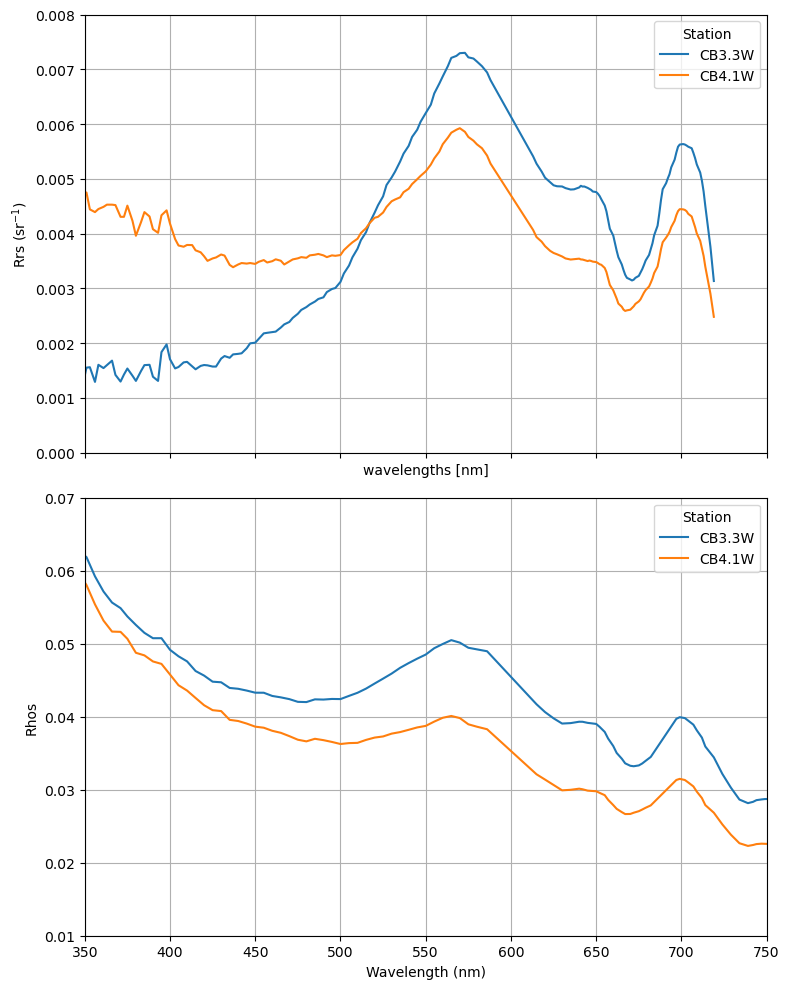

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Stations
# -----------------------------
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149, -76.4627),
]

# -----------------------------
# Lat/lon grids
# -----------------------------
lat_grid = ds["latitude"].values
lon_grid = ds["longitude"].values

# -----------------------------
# Figure: 2 rows, 1 column
# -----------------------------
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 10),
    sharex=True
)

ax_rrs, ax_rhos = axes

# -----------------------------
# Loop over stations
# -----------------------------
for name, plat, plon in stations:

    # Nearest pixel
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)

    # ---- Rrs ----
    rrs_spec = ds["Rrs"].isel(number_of_lines=y, pixels_per_line=x)
    rrs_spec.plot.line(
        x="wavelength_3d",
        ax=ax_rrs,
        label=name
    )
    ax_rrs.set_title(None)  # ✅ remove xarray auto-title

    # ---- Rhos ----
    rhos_spec = ds_rhos["rhos"].isel(number_of_lines=y, pixels_per_line=x)
    rhos_spec.plot.line(
        x="wavelength_3d",
        ax=ax_rhos,
        label=name
    )
    ax_rhos.set_title(None)  # ✅ remove xarray auto-title

# -----------------------------
# Formatting
# -----------------------------
ax_rrs.set_ylabel("Rrs (sr$^{-1}$)")
ax_rrs.set_ylim(0, 0.008)
ax_rrs.set_xlim(350, 800)
ax_rrs.grid(True)
ax_rrs.legend(title="Station")

ax_rhos.set_ylabel("Rhos")
ax_rhos.set_xlim(350, 750)
ax_rhos.set_ylim(0.01, 0.07)
ax_rhos.grid(True)
ax_rhos.legend(title="Station")

ax_rhos.set_xlabel("Wavelength (nm)")

# -----------------------------
# Final layout
# -----------------------------
fig.tight_layout()

fig.savefig(
    'SpectraForStations_ChesBay.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

In [ ]:
wavelengths = ds["wavelength_3d"]

In [ ]:
#code from rrs_viz_new notebook

from scipy.signal import savgol_filter
window = 11      # must be odd, tweak as needed
polyorder = 3

cmap = plt.get_cmap("jet")
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(8, 5))
ymin, ymax = np.inf, -np.inf
dlam = np.mean(np.diff(wavelengths))

for spectrum, avw_val in zip(rrs_sel.values, avw_sel.values):
    # Savitzky–Golay 2nd derivative
    spec_sg2 = savgol_filter(spectrum, window_length=window, polyorder=polyorder, deriv=2, delta=dlam)
    ymin = min(ymin, np.nanmin(spec_sg2))
    ymax = max(ymax, np.nanmax(spec_sg2))
    color = cmap(norm(avw_val))
    ax.plot(wavelengths, spec_sg2, color=color, linewidth=0.8)

ax.set_title("Savitzky–Golay 2nd Derivative of Rrs")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$d^2 R_{rs} / d\lambda^2$")
ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
# Symmetric limits help derivatives
lim = max(abs(ymin), abs(ymax))
ax.set_ylim(-lim, lim)
# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("AVW (nm)")

plt.show()

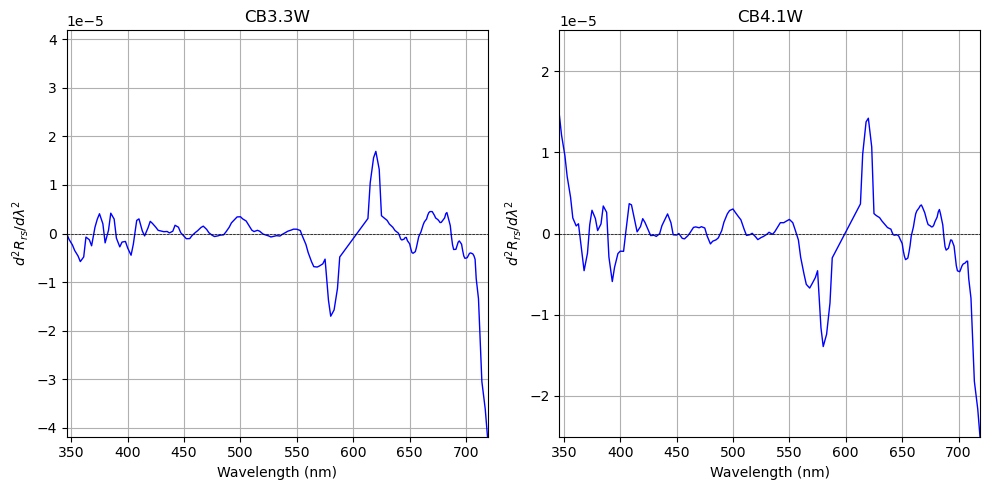

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib import colors

# ---- Parameters ----
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149, -76.4627),
]

window = 11      # must be odd
polyorder = 3

# Lat/lon grids
lat_grid = ds["latitude"].values
lon_grid = ds["longitude"].values

# Wavelengths
wavelengths = ds["Rrs"].wavelength_3d.values
dlam = np.mean(np.diff(wavelengths))

# Subplots
n_stations = len(stations)
fig, axes = plt.subplots(1, n_stations, figsize=(10, 5))
axes = np.atleast_1d(axes)  # ensure iterable

# Colormap for plotting derivatives (optional)
cmap = plt.get_cmap("jet")
vmin, vmax = wavelengths.min(), wavelengths.max()  # just example; adjust if needed
norm = colors.Normalize(vmin=vmin, vmax=vmax)

for i, (name, plat, plon) in enumerate(stations):
    # Find nearest pixel
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    
    # Extract spectrum
    spectrum = ds["Rrs"].isel(number_of_lines=y, pixels_per_line=x).values
    
    # Compute 2nd derivative
    spec_sg2 = savgol_filter(spectrum, window_length=window, polyorder=polyorder, deriv=2, delta=dlam)
    
    # Plot
    ax = axes[i]
    ax.plot(wavelengths, spec_sg2, color="blue", linewidth=1)
    ax.set_title(f"{name}")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel(r"$d^2 R_{rs} / d\lambda^2$")
    ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax.grid(True)
    
    # Set symmetric y-limits for clarity
    lim = np.max(np.abs(spec_sg2))
    ax.set_ylim(-lim, lim)
    ax.set_xlim(wavelengths.min(), wavelengths.max())

plt.tight_layout()
plt.show()


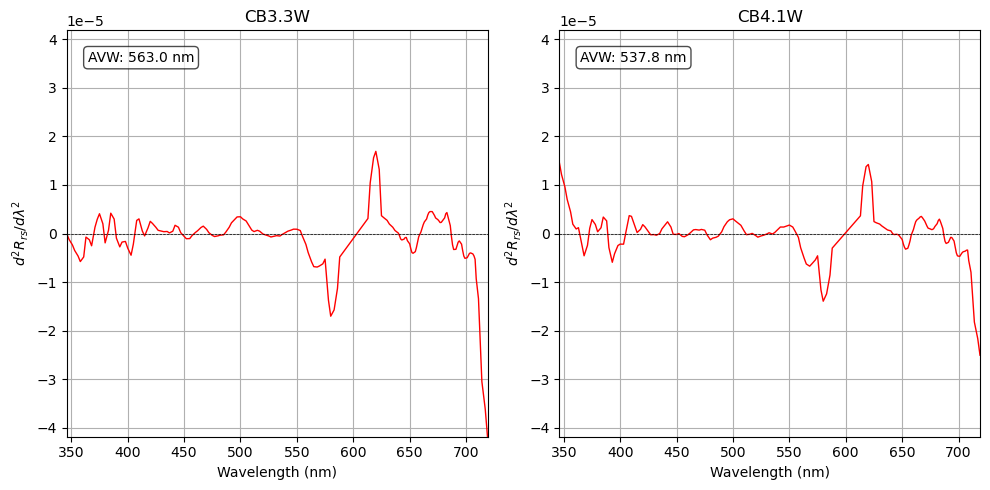

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ---- Parameters ----
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149, -76.4627),
]

window = 11      # must be odd
polyorder = 3

# Lat/lon grids
lat_grid = ds["latitude"].values
lon_grid = ds["longitude"].values

# Wavelengths
wavelengths = ds["Rrs"].wavelength_3d.values
dlam = np.mean(np.diff(wavelengths))

# AVW values
avw_da = ds["avw"]

# Precompute min/max across all stations for symmetric axes
spec_max = -np.inf
spec_min = np.inf
for name, plat, plon in stations:
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    spectrum = ds["Rrs"].isel(number_of_lines=y, pixels_per_line=x).values
    spec_sg2 = savgol_filter(spectrum, window_length=window, polyorder=polyorder, deriv=2, delta=dlam)
    spec_max = max(spec_max, np.max(np.abs(spec_sg2)))
    
# ---- Plot ----
n_stations = len(stations)
fig, axes = plt.subplots(1, n_stations, figsize=(10, 5))
axes = np.atleast_1d(axes)  # ensure iterable

for i, (name, plat, plon) in enumerate(stations):
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    
    spectrum = ds["Rrs"].isel(number_of_lines=y, pixels_per_line=x).values
    spec_sg2 = savgol_filter(spectrum, window_length=window, polyorder=polyorder, deriv=2, delta=dlam)
    
    # AVW for this station
    avw_val = avw_da.isel(number_of_lines=y, pixels_per_line=x).values
    
    # Plot
    ax = axes[i]
    ax.plot(wavelengths, spec_sg2, color="red", linewidth=1)
    ax.set_title(f"{name}")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel(r"$d^2 R_{rs} / d\lambda^2$")
    ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax.grid(True)
    
    # Same axes limits
    ax.set_xlim(wavelengths.min(), wavelengths.max())
    ax.set_ylim(-spec_max, spec_max)
    
    # Add AVW as a textbox
    ax.text(0.05, 0.95, f"AVW: {avw_val:.1f} nm",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()


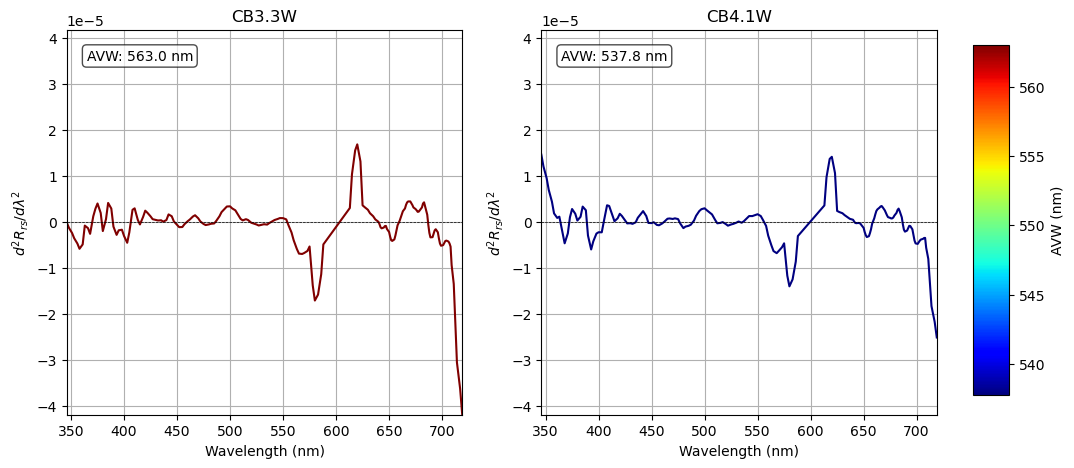

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib import colors

# ---- Parameters ----
stations = [
    ("CB3.3W", 39.00462, -76.3881),
    ("CB4.1W", 38.8149, -76.4627),
]

window = 11      # must be odd
polyorder = 3

lat_grid = ds["latitude"].values
lon_grid = ds["longitude"].values

wavelengths = ds["Rrs"].wavelength_3d.values
dlam = np.mean(np.diff(wavelengths))

avw_da = ds["avw"]

# AVW values for colormap
avw_values = []
for name, plat, plon in stations:
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    avw_values.append(avw_da.isel(number_of_lines=y, pixels_per_line=x).values)
avw_values = np.array(avw_values)
vmin, vmax = np.min(avw_values), np.max(avw_values)

cmap = plt.get_cmap("jet")
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Global y-limit
spec_max = -np.inf
for name, plat, plon in stations:
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    spectrum = ds["Rrs"].isel(number_of_lines=y, pixels_per_line=x).values
    spec_sg2 = savgol_filter(spectrum, window_length=window, polyorder=polyorder, deriv=2, delta=dlam)
    spec_max = max(spec_max, np.max(np.abs(spec_sg2)))

# ---- Plot with space for colorbar ----
n_stations = len(stations)
fig, axes = plt.subplots(1, n_stations, figsize=(12, 5), gridspec_kw={'right': 0.85})
axes = np.atleast_1d(axes)

for i, (name, plat, plon) in enumerate(stations):
    dist = np.sqrt((lat_grid - plat)**2 + (lon_grid - plon)**2)
    y, x = np.unravel_index(dist.argmin(), dist.shape)
    
    spectrum = ds["Rrs"].isel(number_of_lines=y, pixels_per_line=x).values
    spec_sg2 = savgol_filter(spectrum, window_length=window, polyorder=polyorder, deriv=2, delta=dlam)
    
    avw_val = avw_da.isel(number_of_lines=y, pixels_per_line=x).values
    color = cmap(norm(avw_val))
    
    ax = axes[i]
    ax.plot(wavelengths, spec_sg2, color=color, linewidth=1.5)
    ax.set_title(f"{name}")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel(r"$d^2 R_{rs} / d\lambda^2$")
    ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax.grid(True)
    ax.set_xlim(wavelengths.min(), wavelengths.max())
    ax.set_ylim(-spec_max, spec_max)
    
    # Add AVW textbox
    ax.text(0.05, 0.95, f"AVW: {avw_val:.1f} nm",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# ---- Add colorbar outside the subplots ----
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("AVW (nm)")

plt.show()
